In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score

import albumentations as A
import cv2
from PIL import Image

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint

In [2]:
test = pd.read_csv('../input/digit-recognizer/test.csv')
train =  pd.read_csv('../input/digit-recognizer/train.csv')

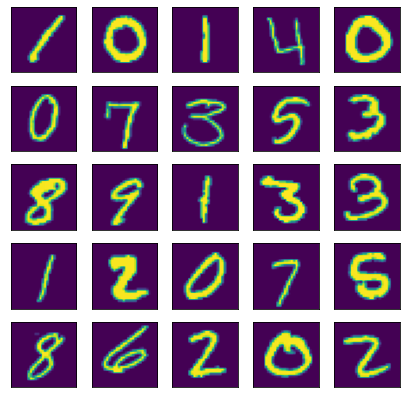

In [3]:
fig, axes = plt.subplots(5,5,subplot_kw={'xticks': (), 'yticks': ()},figsize=(7,7))
for ax,img in zip(axes.ravel(),train.drop(columns='label').values):
    ax.imshow(img.reshape(28,28))

In [4]:
xtrain, xtest, ytrain, ytest = train_test_split(train.drop(columns='label').to_numpy()/255,train['label'])

In [5]:
model_KNN = KNeighborsClassifier(n_jobs=-1,n_neighbors=15)

In [6]:
model_KNN.fit(xtrain,ytrain)
pred_proba = model_KNN.predict_proba(xtest)
pred = model_KNN.predict(xtest)

In [7]:
score = [f1_score(ytest,pred,average='micro'), roc_auc_score(ytest,pred_proba,multi_class='ovo')]
score

[0.9571428571428572, 0.99743595015323]

In [8]:
transform = A.Compose([
    A.ElasticTransform(always_apply=False, p=1, alpha=1.5, sigma=1.5, alpha_affine=0.5, interpolation=1),
    #A.Blur(2,p=0.5),
    #A.ShiftScaleRotate(p=0.5, interpolation=1, border_mode=1,rotate_limit=20,scale_limit=0.3,shift_limit=0.07,always_apply=True)

])
xtrain_transform_KNN = []
for i in xtrain:
    xtrain_transform_KNN.append(transform(image=i.reshape(28,28))['image'].reshape(28*28))


In [9]:
model_KNN.fit(xtrain_transform_KNN,ytrain)
pred_proba_aug = model_KNN.predict_proba(xtest)
pred_aug = model_KNN.predict(xtest)

In [10]:
score_aug = [f1_score(ytest,pred_aug,average='micro'), roc_auc_score(ytest,pred_proba_aug,multi_class='ovo')]
score_aug

[0.9613333333333334, 0.9977288100749536]

In [11]:
def plot_history(history):
    plt.figure(figsize=(15,5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('epoch')
    plt.legend(['train_auc', 'test_auc', 'train_los', 'test_los'], loc=0)
    x_los, y_los = np.argmin(history.history['val_loss']), min(history.history['val_loss'])
    plt.scatter(x_los, y_los)
    plt.text(x_los-0.3, y_los+0.05,'min loss',size=14)
    x_auc, y_auc = np.argmax(history.history['val_accuracy']), max(history.history['val_accuracy'])
    plt.scatter(x_auc, y_auc)
    plt.text(x_auc-0.3, y_auc+0.05,'max auc: \n {}'.format(round(max(history.history['val_accuracy']),5)),size=14)
    plt.show()

In [12]:
batch_size = 128
epochs = 10
img_rows, img_cols = 28, 28
num_classes=10

In [13]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
     activation='relu',
     input_shape=(img_rows, img_cols, 1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])

In [14]:
history = model.fit(xtrain.reshape(-1,28,28,1), ytrain,
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              validation_data=(xtest.reshape(-1,28,28,1), ytest))

In [15]:
score = model.evaluate(xtest.reshape(-1,28,28,1), ytest, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
model.save("test_model.h5")

Test loss: 0.04188748076558113
Test accuracy: 0.9887619018554688


In [16]:
score = [f1_score(ytest,model.predict_classes(xtest.reshape(-1,28,28,1)),average='micro'), roc_auc_score(ytest,model.predict(xtest.reshape(-1,28,28,1)),multi_class='ovo')]
score

[0.9887619047619047, 0.9998708031975361]

In [17]:
transform = A.Compose([
    A.ElasticTransform(always_apply=False, p=1, alpha=2, sigma=1.5, alpha_affine=1, interpolation=1),
    A.ShiftScaleRotate(p=1, interpolation=1, border_mode=1,rotate_limit=20,scale_limit=0.3,shift_limit=0.07,always_apply=True),
    A.OneOf([
        A.Cutout(always_apply=False, p=0.5, num_holes=20, max_h_size=2, max_w_size=2),
        A.MotionBlur(always_apply=False, p=0.5, blur_limit=(4, 5))
    ], p=1)

])
xtrain_transform = []
for i in xtrain:
    xtrain_transform.append(transform(image=i.reshape(28,28))['image'].reshape(28*28))
xtrain_transform = np.array(xtrain_transform).reshape(-1,28,28,1)

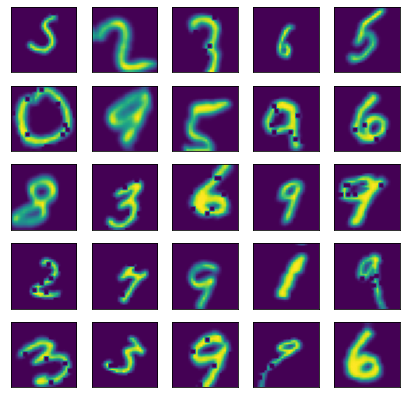

In [18]:
fig, axes = plt.subplots(5,5,subplot_kw={'xticks': (), 'yticks': ()},figsize=(7,7))
for ax,img in zip(axes.ravel(),xtrain_transform):
    ax.imshow(img.reshape(28,28))

In [19]:
filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history_Aug = model.fit(xtrain_transform, ytrain,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=0,
                  callbacks=checkpoint,
                  validation_data=(xtest.reshape(-1,28,28,1), ytest))
model.load_weights('weights.hdf5')


Epoch 00001: val_accuracy improved from -inf to 0.98800, saving model to weights.hdf5

Epoch 00002: val_accuracy did not improve from 0.98800

Epoch 00003: val_accuracy improved from 0.98800 to 0.98962, saving model to weights.hdf5

Epoch 00004: val_accuracy improved from 0.98962 to 0.99019, saving model to weights.hdf5

Epoch 00005: val_accuracy did not improve from 0.99019

Epoch 00006: val_accuracy did not improve from 0.99019

Epoch 00007: val_accuracy did not improve from 0.99019

Epoch 00008: val_accuracy did not improve from 0.99019

Epoch 00009: val_accuracy did not improve from 0.99019

Epoch 00010: val_accuracy did not improve from 0.99019


In [20]:
score = [f1_score(ytest,model.predict_classes(xtest.reshape(-1,28,28,1)),average='micro'), roc_auc_score(ytest,model.predict(xtest.reshape(-1,28,28,1)),multi_class='ovo')]
score

[0.9901904761904762, 0.9999008813824195]

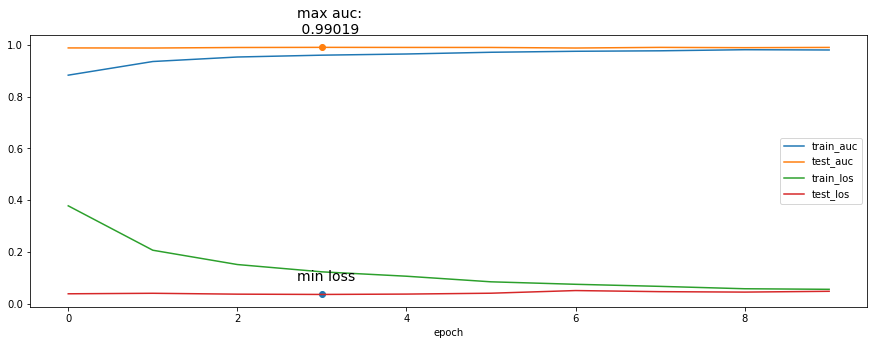

In [21]:
plot_history(history_Aug)

In [22]:
merge_xtrain, merge_ytrain = np.concatenate((xtrain.reshape(-1,28,28,1), xtrain_transform)), np.concatenate((ytrain, ytrain))

In [23]:
filepath="weights_merge.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history_Merge = model.fit(merge_xtrain, merge_ytrain,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=0,
                  callbacks=checkpoint,
                  validation_data=(xtest.reshape(-1,28,28,1), ytest))
model.load_weights('weights_merge.hdf5')



Epoch 00001: val_accuracy improved from -inf to 0.99105, saving model to weights_merge.hdf5

Epoch 00002: val_accuracy improved from 0.99105 to 0.99114, saving model to weights_merge.hdf5

Epoch 00003: val_accuracy improved from 0.99114 to 0.99248, saving model to weights_merge.hdf5

Epoch 00004: val_accuracy did not improve from 0.99248

Epoch 00005: val_accuracy did not improve from 0.99248

Epoch 00006: val_accuracy did not improve from 0.99248

Epoch 00007: val_accuracy did not improve from 0.99248

Epoch 00008: val_accuracy did not improve from 0.99248

Epoch 00009: val_accuracy improved from 0.99248 to 0.99314, saving model to weights_merge.hdf5

Epoch 00010: val_accuracy did not improve from 0.99314


In [24]:
score = [f1_score(ytest,model.predict_classes(xtest.reshape(-1,28,28,1)),average='micro'), roc_auc_score(ytest,model.predict(xtest.reshape(-1,28,28,1)),multi_class='ovo')]
score

[0.9931428571428571, 0.9999499308593228]

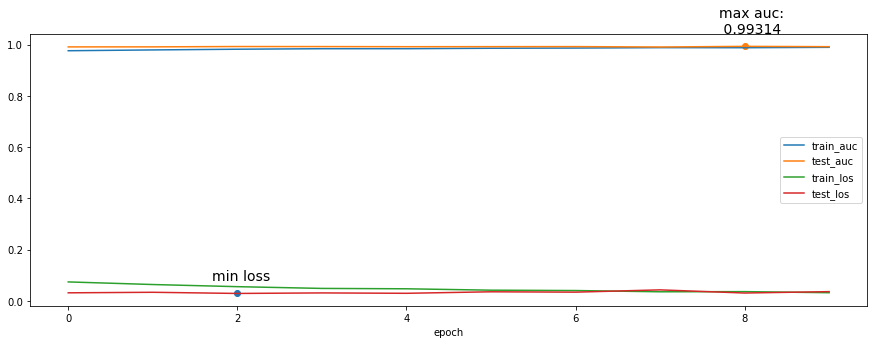

In [25]:
plot_history(history_Merge)

In [26]:
test = pd.read_csv('../input/digit-recognizer/test.csv')
as_we_can = model.predict_classes(test.values.reshape(-1,28,28,1))
output = pd.Series(as_we_can, name="Label")
submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"), output], axis = 1)
submission.to_csv("submission.csv", index=False)